In [1]:
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from matplotlib import style
import numpy as np
import random
import serial
import time
import struct

In [328]:
ser.close()

In [131]:
#initialize serial port
ser = serial.Serial()
ser.port = 'COM3' #Arduino serial port
ser.baudrate = 256000
ser.timeout = 10 #specify timeout when using readline()
ser.open()
if ser.is_open==True:
	print("\nAll right, serial port now open. Configuration:\n")
	# print(ser, "\n") #print serial parameters

read_time = 5 # in sec

time.sleep(10) # wait until initialization of board
start_time = time.time()
lines = []
ser.reset_input_buffer()
while time.time() - start_time <=  read_time:
    line = ser.readline()              #ascii
    lines.append(line)
ser.close()


All right, serial port now open. Configuration:



In [132]:
numofreads_motor = 0
numofreads_IMU = 0
motor_data_columns_num = 4
motor_data = np.zeros((0,motor_data_columns_num))
IMU_data_columns_num = 4
IMU_data = np.zeros((0,IMU_data_columns_num))
for line in lines:
    # motor state 
    if struct.pack('h', line[0])==b'\xFE\x00' and struct.pack('h', line[1])==b'\xEF\x00': 
        if len(line) == 16:
            numofreads_motor += 1
            val = np.zeros((1,motor_data_columns_num))[0]
            val[0] = struct.unpack('I',line[2:6])[0]
            val[1] = struct.unpack('H',line[6:8])[0]
            val[2] = struct.unpack('H',line[8:10])[0]
            val[3] = struct.unpack('f',line[10:14])[0]
            motor_data = np.vstack((motor_data,val))

    if struct.pack('h', line[0])==b'\xFC\x00' and struct.pack('h', line[1])==b'\xCF\x00': 
        if len(line) == 16:
            numofreads_IMU += 1
            val = np.zeros((1,IMU_data_columns_num))[0]
            val[0] = struct.unpack('f',line[2:6])[0]
            val[1] = struct.unpack('f',line[6:10])[0]
            val[2] = struct.unpack('f',line[10:14])[0]
            IMU_data = np.vstack((IMU_data,val))
print("number of readings motor: {}".format(numofreads_motor))
print("number of readings IMU: {}".format(numofreads_IMU))
dt = read_time*1e3/numofreads_motor
print("average time on one reading: {} msec".format(dt))

ser.close()

t = (motor_data[:,0]-motor_data[0,0])*1e-3*0.1220703125
a = motor_data[:,2]*0.2932551319648094
halfT = motor_data[:,3]
angle_motion = motor_data[:,1]*0.2932551319648094
# angle_mode = vals[:,2]*0.2932551319648094

yaw = IMU_data[:,0]
pitch = IMU_data[:,1]
roll = IMU_data[:,2]

number of readings motor: 220
number of readings IMU: 213
average time on one reading: 22.727272727272727 msec


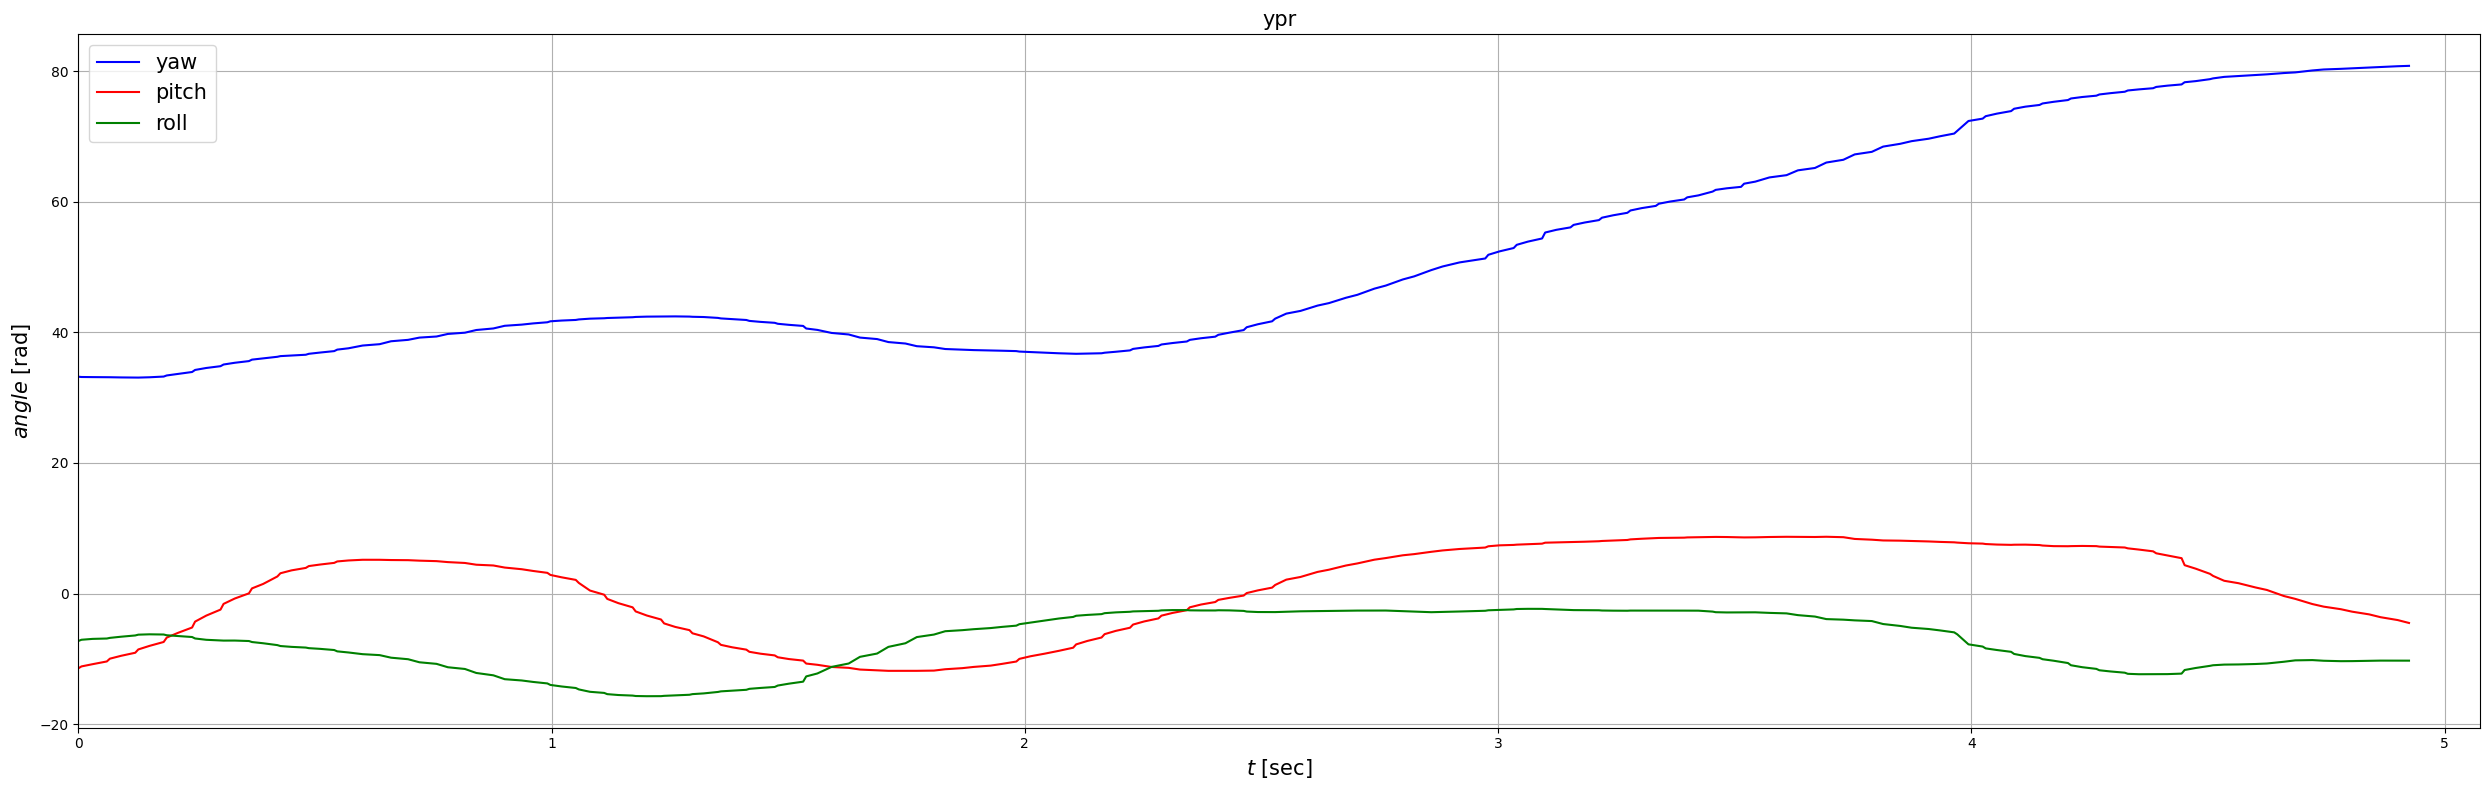

In [133]:
import scipy as sp

# v = np.ones(5)/5
# a1 = np.convolve(a, v, mode='same')
# a2 = np.convolve(angle_motion, v, mode='same')

# plt.figure(figsize = (25,8))
# plt.plot(t,a1,"-b",label="$\\alpha_{goal}$")
# plt.plot(t,a2,"-r",label="$\\alpha_{motion}$")
# plt.title("a",fontsize=15)
# plt.xlabel("$t$ [sec]",fontsize=15)
# plt.ylabel("$a$ [deg]",fontsize=15)
# plt.grid(True)
# plt.xlim([0 ,t[-1]])
# plt.yticks(np.arange(40, 165, step=10))
# # plt.ylim([0,200])
# plt.legend( fontsize=15)
# plt.tight_layout()
# plt.show()


a1 = np.rad2deg(yaw)
a2 = np.rad2deg(pitch)
a3 = np.rad2deg(roll)
# window = 41
# v = np.ones(window)/window
# a1 = np.convolve(yaw, v, mode='same')
# a2 = np.convolve(pitch, v, mode='same')
# a3 = np.convolve(roll, v, mode='same')

plt.figure(figsize = (25,8))
plt.plot(t[:np.min([numofreads_motor,numofreads_IMU])],a1[:np.min([numofreads_motor,numofreads_IMU])],"-b",label="yaw")
plt.plot(t[:np.min([numofreads_motor,numofreads_IMU])],a2[:np.min([numofreads_motor,numofreads_IMU])],"-r",label="pitch")
plt.plot(t[:np.min([numofreads_motor,numofreads_IMU])],a3[:np.min([numofreads_motor,numofreads_IMU])],"-g",label="roll")
plt.title("ypr",fontsize=15)
plt.xlabel("$t$ [sec]",fontsize=15)
plt.ylabel("$angle$ [rad]",fontsize=15)
plt.grid(True)
plt.xlim([0 ,t[-1]])
plt.legend( fontsize=15)
plt.tight_layout()
plt.show()

In [130]:
328*3

984

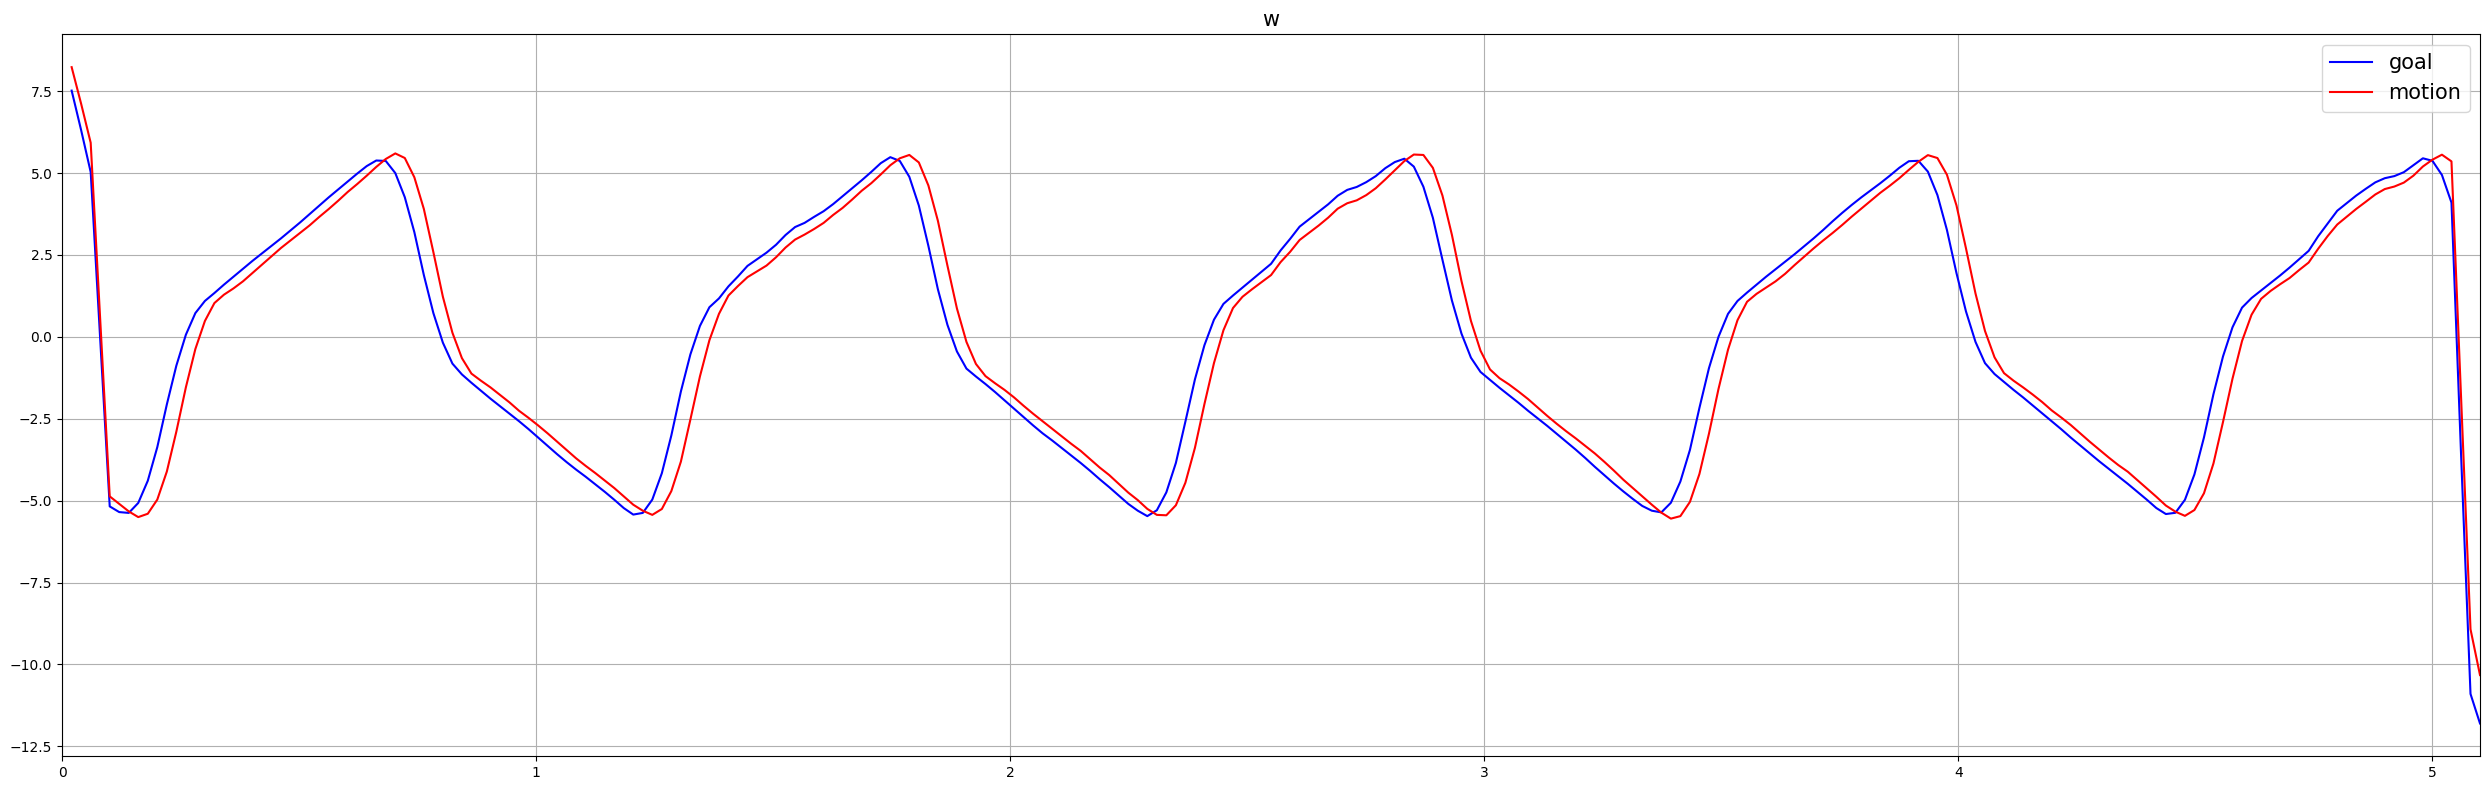

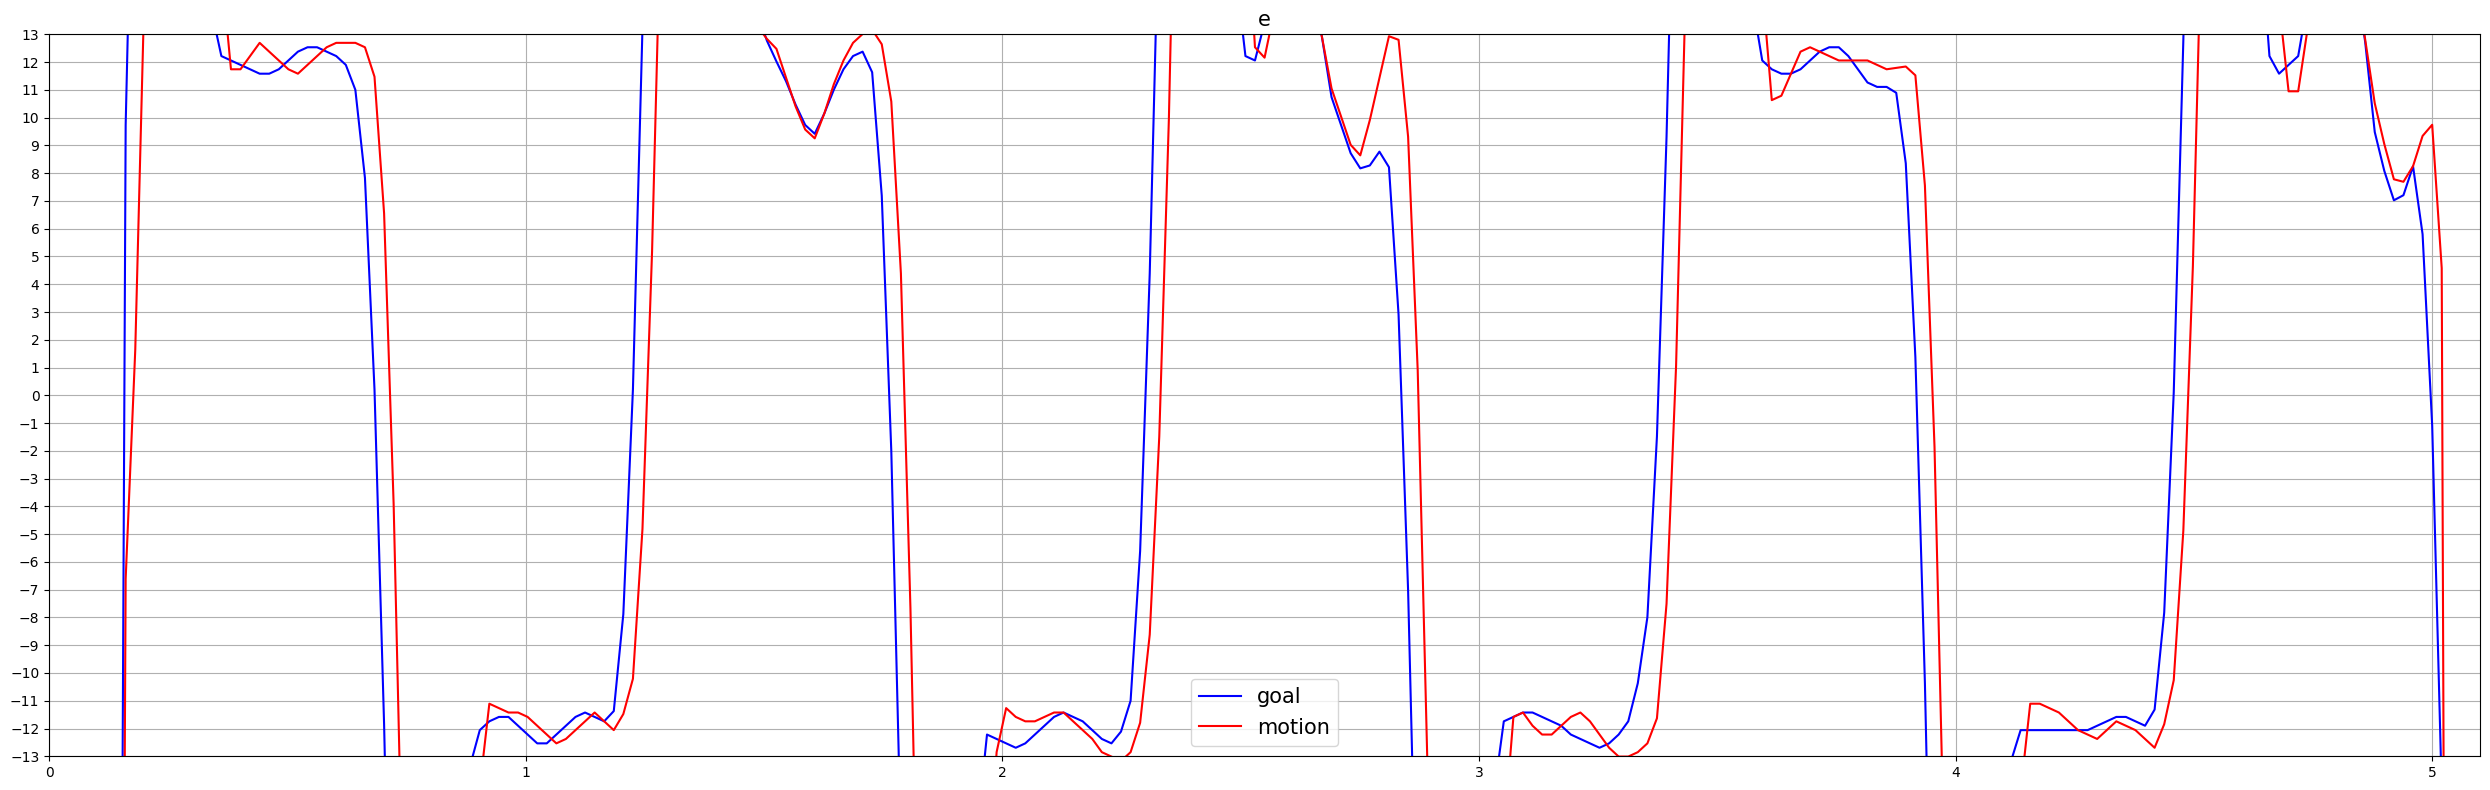

In [71]:
dt = np.diff(t)

window = 4
wg = np.divide(   np.deg2rad( np.diff(a1)), dt) 
wr = np.divide(   np.deg2rad( np.diff(a2)), dt)
wg = sp.signal.medfilt(wg, kernel_size=3)
wr = sp.signal.medfilt(wr, kernel_size=3)
v = np.ones(window)/window
wg = np.convolve( wg , v, mode='same')
wr = np.convolve( wr, v, mode='same')

eg = np.divide(  np.diff(wg), dt[1:] )
er = np.divide(  np.diff(wr), dt[1:] )
eg = sp.signal.medfilt(eg, kernel_size=3)
er = sp.signal.medfilt(er, kernel_size=3)
v = np.ones(window)/window
eg = np.convolve( eg, v, mode='same')
er = np.convolve( er, v, mode='same')

plt.figure(figsize = (25,8))
plt.plot(t[1:],wg,"-b",label="goal")
plt.plot(t[1:],wr,"-r",label="motion")
plt.title("w",fontsize=15)
plt.grid(True)
plt.xlim([0 ,t[-1]])
# plt.ylim([-2 ,2])
plt.legend( fontsize=15)
plt.tight_layout()
plt.show()

plt.figure(figsize = (25,8))
plt.plot(t[2:],eg,"-b",label="goal")
plt.plot(t[2:],er,"-r",label="motion")
plt.title("e",fontsize=15)
plt.grid(True)
plt.xlim([0 ,t[-1]])
lim=13
plt.ylim([-lim ,lim])
plt.yticks(np.arange(-lim, lim+1, step=1))
plt.legend( fontsize=15)
plt.tight_layout()
plt.show()

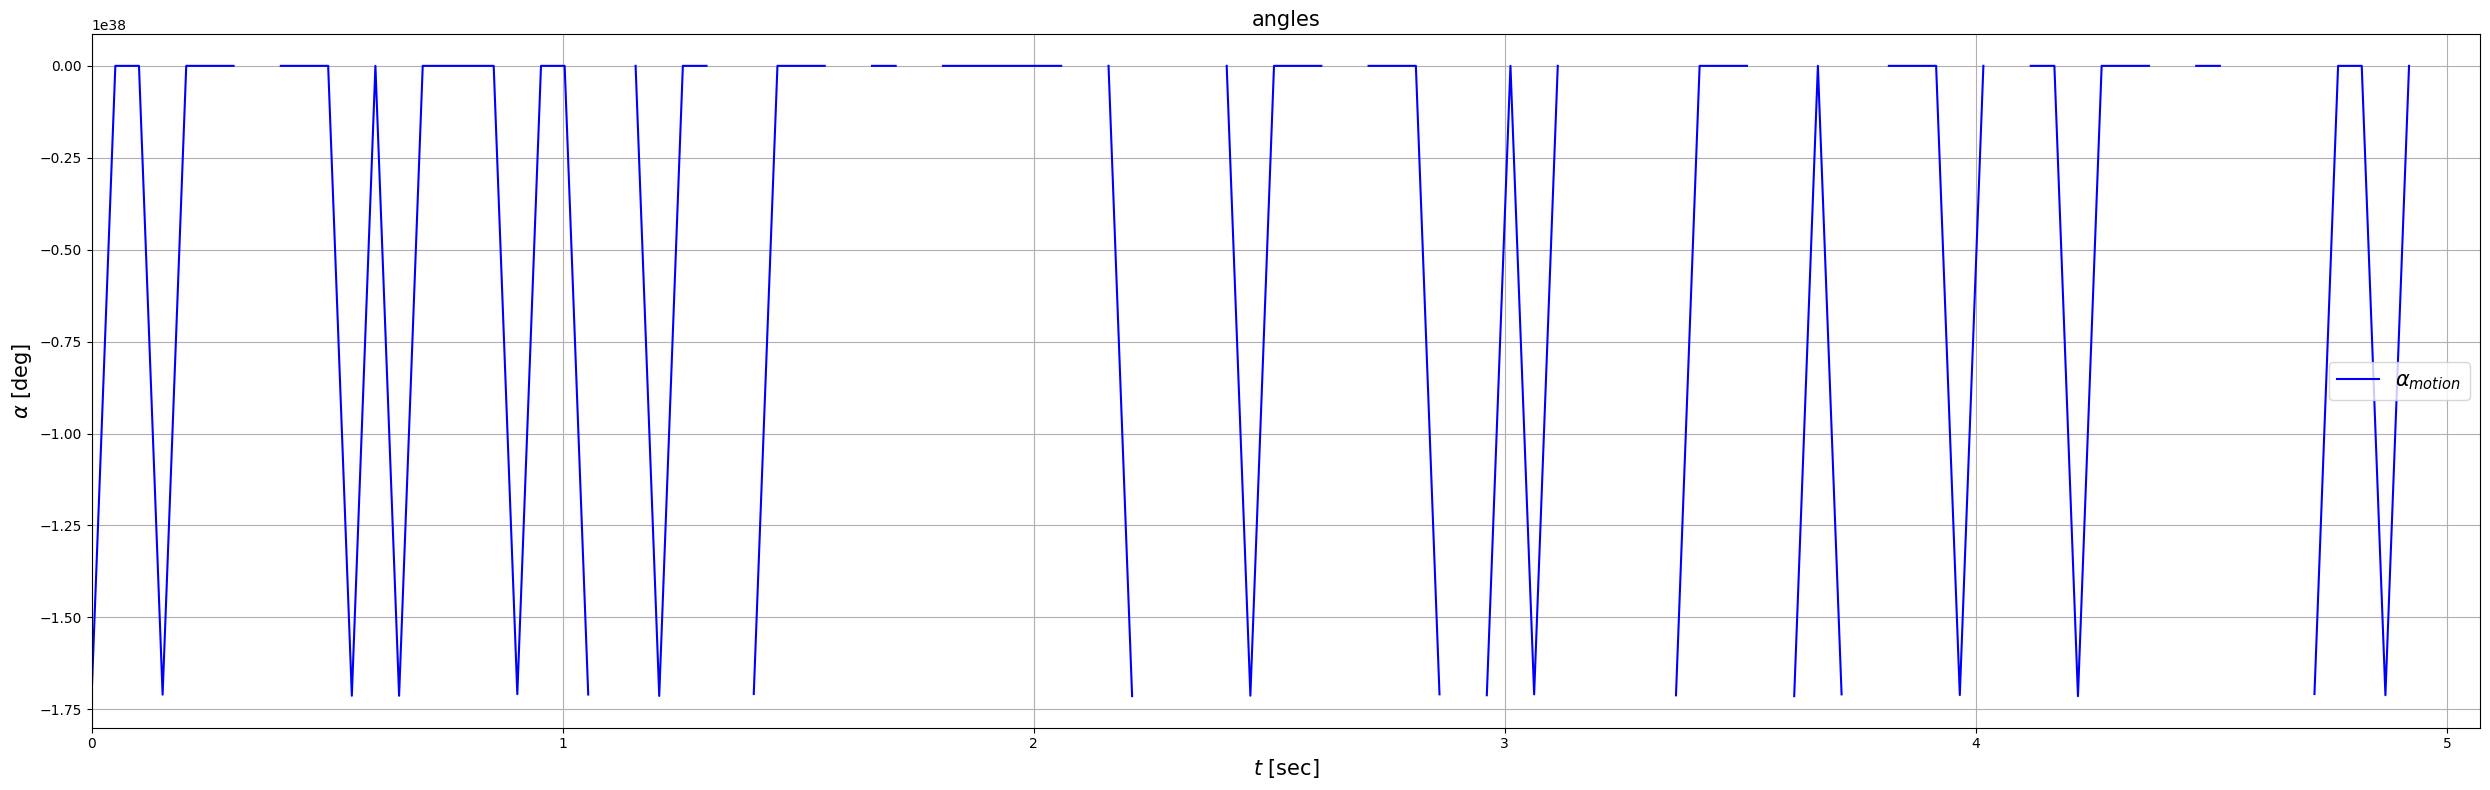

In [316]:
plt.figure(figsize = (25,8))
plt.plot(t,angle_motion,"-b",label="$\\alpha_{motion}$")
# plt.plot(t,angle_mode,"-r",label="$\\alpha_{mode}$")
plt.title("angles",fontsize=15)
plt.xlabel("$t$ [sec]",fontsize=15)
plt.ylabel("$\\alpha$ [deg]",fontsize=15)
plt.grid(True)
plt.xlim([0 ,t[-1]])
# plt.ylim([0,500])
plt.legend( fontsize=15)
plt.tight_layout()
plt.show()

In [302]:
3.4099999999999997*60

204.6

In [ ]:
# plt.subplots(2,1,figsize = (20,6))
# plt.subplot(211)

# plt.subplot(212)
# plt.plot(self.x_phi_true,self.y_phi_true)
# plt.axis('equal')
# plt.title("given beam shape (x,y)",fontsize=15)
# plt.xlabel("$x$ [mm]",fontsize=15)
# plt.ylabel("$y$ [mm]",fontsize=15)
# plt.grid(True)

In [280]:
ser.close()